In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
##load data 

data = pd.read_csv(r"C:\Users\uniq\Downloads\medical_insurance.csv")

In [4]:
df = pd.DataFrame(data)

# Check for missing values and duplicates
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

# Step 4: Feature Engineering - BMI classification
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df_encoded["bmi_category"] = df["bmi"].apply(bmi_category)

# Step 5: Scale numerical features
scaler = StandardScaler()
scaled_cols = ["age", "bmi", "children", "charges"]
df_encoded[scaled_cols] = scaler.fit_transform(df_encoded[scaled_cols])

# Final Preprocessed Dataset
print("\nPreprocessed Data:\n", df_encoded.head())

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Duplicates: 1435

Preprocessed Data:
         age       bmi  children   charges  sex_male  smoker_yes  \
0 -1.428353 -0.457114 -0.907084  0.298245     False        True   
1 -1.499381  0.500731 -0.083758 -0.949483      True       False   
2 -0.789099  0.375085  1.562893 -0.725285      True       False   
3 -0.433959 -1.304814 -0.907084  0.717976      True       False   
4 -0.504987 -0.297201 -0.907084 -0.773238      True       False   

   region_northwest  region_southeast  region_southwest bmi_category  
0             False             False              True   Overweight  
1             False              True             False        Obese  
2             False              True             False        Obese  
3              True             False             False       Normal  
4              True             False             False   Overweight  


In [6]:
# ============================
# Step 2 — Medical Insurance Cost Prediction (EDA + Models + MLflow)
# ============================

import os, math, warnings, json
warnings.filterwarnings("ignore")

# --- Optional import of xgboost ---
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# === Ensure `df` exists (user should have loaded df earlier) ===
# e.g. df = pd.read_csv("data/insurance.csv")
# -------------------------------------------------------------

# 2) Quick EDA (artifacts saved)
# -----------------------------
os.makedirs("artifacts", exist_ok=True)

# Summary stats
df.describe(include="all").to_csv("artifacts/summary_stats.csv")

# Numerical correlation heatmap
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != "charges"] + ["charges"]
num_cols = [c for c in num_cols if c in df.columns]
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numerical)")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig("artifacts/corr_heatmap.png")
    plt.close()

# Charges by smoker (if exists)
if "smoker" in df.columns:
    plt.figure()
    df.boxplot(column="charges", by="smoker")
    plt.title("Charges by smoker")
    plt.suptitle("")
    plt.xlabel("Smoker")
    plt.ylabel("Charges")
    plt.tight_layout()
    plt.savefig("artifacts/charges_by_smoker.png")
    plt.close()

# Charges vs BMI (if exists)
if "bmi" in df.columns:
    plt.figure()
    plt.scatter(df["bmi"], df["charges"])
    plt.xlabel("BMI"); plt.ylabel("Charges"); plt.title("Charges vs BMI")
    plt.tight_layout()
    plt.savefig("artifacts/charges_vs_bmi.png")
    plt.close()

# Charges vs Age (if exists)
if "age" in df.columns:
    plt.figure()
    plt.scatter(df["age"], df["charges"])
    plt.xlabel("Age"); plt.ylabel("Charges"); plt.title("Charges vs Age")
    plt.tight_layout()
    plt.savefig("artifacts/charges_vs_age.png")
    plt.close()

# -----------------------------
# 3) Train/Test split
# -----------------------------
TARGET = "charges"
X = df.drop(columns=[TARGET])
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -----------------------------
# -----------------------------
# 4) Preprocessing pipeline
# -----------------------------
cat_cols = list(X.select_dtypes(include=["object", "category"]).columns)
num_cols = list(X.select_dtypes(include=[np.number]).columns)

# Safe OneHotEncoder (works with sklearn <1.2 and >=1.2)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # new versions
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)        # old versions

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

# -----------------------------
# 5) Models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, min_samples_leaf=1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR_RBF": SVR(kernel="rbf", C=10.0, epsilon=0.2),
}
if XGB_AVAILABLE:
    models["XGBoost"] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
    )

# -----------------------------
# 6) MLflow setup
# -----------------------------
mlflow.set_tracking_uri("mlruns")  # local folder tracking (change if you have a server)
experiment_name = "Medical_Insurance_Cost_Regression"
mlflow.set_experiment(experiment_name)

def eval_metrics(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

run_records = []

# -----------------------------
# 7) Train, evaluate, and log
# -----------------------------
for name, estimator in models.items():
    with mlflow.start_run(run_name=name) as run:
        # Build pipeline
        pipe = Pipeline([("prep", preprocess), ("model", estimator)])
        pipe.fit(X_train, y_train)

        # Predictions
        y_pred_tr = pipe.predict(X_train)
        y_pred_te = pipe.predict(X_test)

        # Metrics
        tr_rmse, tr_mae, tr_r2 = eval_metrics(y_train, y_pred_tr)
        te_rmse, te_mae, te_r2 = eval_metrics(y_test, y_pred_te)

        # Log params (from estimator)
        try:
            params = pipe.named_steps["model"].get_params()
            params = {k: v for k, v in params.items()
                      if isinstance(v, (int, float, str, bool, type(None)))}
            mlflow.log_params(params)
        except Exception:
            pass

        # Log metrics
        mlflow.log_metrics({
            "train_rmse": tr_rmse, "train_mae": tr_mae, "train_r2": tr_r2,
            "test_rmse": te_rmse,  "test_mae": te_mae,  "test_r2": te_r2
        })

        # Log EDA artifacts (once per run is fine)
        for p in ["artifacts/summary_stats.csv",
                  "artifacts/corr_heatmap.png",
                  "artifacts/charges_by_smoker.png",
                  "artifacts/charges_vs_bmi.png",
                  "artifacts/charges_vs_age.png"]:
            if os.path.exists(p):
                mlflow.log_artifact(p)

        # Model signature + input example
        try:
            sig = infer_signature(X_train, pipe.predict(X_train))
        except Exception:
            sig = None

        # ===== Updated call: use `name=` (replaces deprecated `artifact_path=`) =====
        # This will name the model artifact inside the run with the model short name
        # (e.g., "RandomForest"). Use this name when constructing runs:/ URIs below.
        mlflow.sklearn.log_model(
            sk_model=pipe,
            name=name,
            signature=sig,
            input_example=X_train.head(3)
        )

        run_records.append({
            "name": name,
            "run_id": run.info.run_id,
            "test_rmse": te_rmse,
            "test_mae": te_mae,
            "test_r2": te_r2
        })

# -----------------------------
# 8) Choose RandomForest explicitly & register
# -----------------------------
rf_record = next(r for r in run_records if r["name"] == "RandomForest")
rf_run_id, rf_name = rf_record["run_id"], rf_record["name"]

print("\nRun summary (sorted by Test RMSE):")
for r in sorted(run_records, key=lambda r: r["test_rmse"]):
    print(f"{r['name']:>18} | RMSE={r['test_rmse']:.2f}  "
          f"MAE={r['test_mae']:.2f}  R2={r['test_r2']:.3f}  run_id={r['run_id']}")

# Register (works if your tracking server supports a registry backend)
model_name = "MedicalInsuranceRegressor"

# Since models were logged with name=<model_short_name>, we use that short name in the path
model_uri = f"runs:/{rf_run_id}/{rf_name}"

try:
    result = mlflow.register_model(model_uri=model_uri, name=model_name)
    print(f"\nRandomForest registered as '{model_name}' (version={getattr(result, 'version', 'N/A')}).")
except Exception as e:
    print("\nModel registry not available in this tracking setup.")
    print("RandomForest still logged as an artifact and can be loaded via:")
    print(f"  mlflow.pyfunc.load_model('{model_uri}')")
    print(f"Reason: {e}")



Run summary (sorted by Test RMSE):
      RandomForest | RMSE=3195.62  MAE=1422.95  R2=0.936  run_id=ccdf61dc17a74d1991363297b31d825a
  GradientBoosting | RMSE=4477.45  MAE=2324.67  R2=0.874  run_id=104323c4ebe14ec7b8681c312d7eaecf
  LinearRegression | RMSE=6440.12  MAE=4288.35  R2=0.740  run_id=562f734a47d64da5a1f32d696bbfae8b
             Lasso | RMSE=6440.12  MAE=4288.35  R2=0.740  run_id=4b422afc9ea944158c92fc74e38c9f7f
           SVR_RBF | RMSE=12873.98  MAE=7952.46  R2=-0.039  run_id=4fa990d41f7b4bc5814a4bae525c0bc9


Registered model 'MedicalInsuranceRegressor' already exists. Creating a new version of this model...
2025/09/24 13:36:35 WARNING mlflow.tracking._model_registry.fluent: Run with id ccdf61dc17a74d1991363297b31d825a has no artifacts at artifact path 'RandomForest', registering model based on models:/m-f2a9c6ad0b784b109de26fa1d7543d24 instead



RandomForest registered as 'MedicalInsuranceRegressor' (version=4).


Created version '4' of model 'MedicalInsuranceRegressor'.


<Figure size 640x480 with 0 Axes>

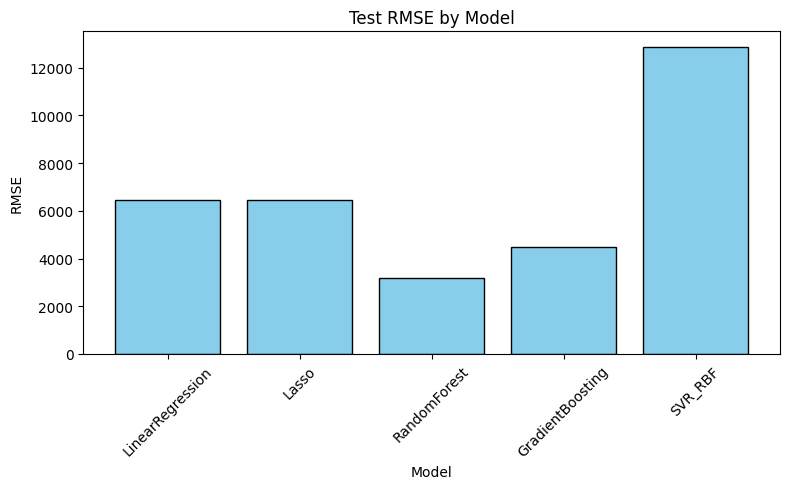

In [7]:
import matplotlib.pyplot as plt

# Create a bar plot of RMSE by model
model_names = [r["name"] for r in run_records]
rmse_scores = [r["test_rmse"] for r in run_records]

plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_scores, color="skyblue", edgecolor="black")
plt.title("Test RMSE by Model")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


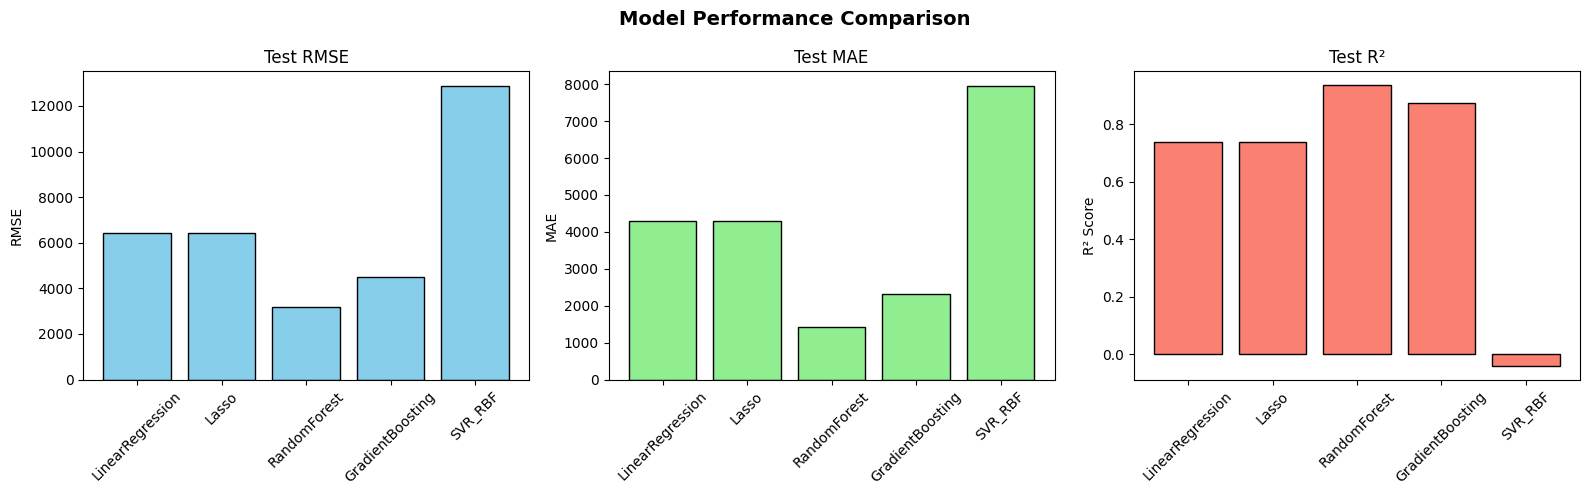

In [8]:
import matplotlib.pyplot as plt

# Extract metrics
model_names = [r["name"] for r in run_records]
rmse_scores = [r["test_rmse"] for r in run_records]
mae_scores = [r["test_mae"] for r in run_records]
r2_scores   = [r["test_r2"] for r in run_records]

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE plot
axes[0].bar(model_names, rmse_scores, color="skyblue", edgecolor="black")
axes[0].set_title("Test RMSE")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis="x", rotation=45)

# MAE plot
axes[1].bar(model_names, mae_scores, color="lightgreen", edgecolor="black")
axes[1].set_title("Test MAE")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis="x", rotation=45)

# R² plot
axes[2].bar(model_names, r2_scores, color="salmon", edgecolor="black")
axes[2].set_title("Test R²")
axes[2].set_ylabel("R² Score")
axes[2].tick_params(axis="x", rotation=45)

plt.suptitle("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Identify categorical and numeric columns
categorical_cols = ["sex", "smoker", "region"]  # adjust based on your dataset
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Preprocessing: scale numerics, one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Define pipelines
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])
rf_params = {"n_estimators": 200, "max_depth": 10, "random_state": 42}

gb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])
gb_params = {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 3, "random_state": 42}

lr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])
lr_params = {}

lasso_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=0.1, random_state=42))
])
lasso_params = {"alpha": 0.1}

svr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR(kernel="rbf", C=100, gamma=0.1))
])
svr_params = {"kernel": "rbf", "C": 100, "gamma": 0.1}


In [2]:
%%writefile app.py
# app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# File paths
csv_path = r"C:\Users\uniq\Downloads\medical_insurance.csv"
model_path = r"C:\Users\uniq\Downloads\insurance_model.pkl"

# Load dataset
data = pd.read_csv(csv_path)

# --- Load or Train Model ---
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
else:
    st.warning("Model not found. Training a new model...")
    
    # Preprocessing
    data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
    
    # Split features and target
    X = data_encoded.drop('charges', axis=1)
    y = data_encoded['charges']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Save model
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    st.success("Model trained and saved!")

# Streamlit App UI
st.title("Medical Insurance Cost Prediction")

# --- EDA Section ---
st.header("Exploratory Data Analysis Insights")

# Smoking vs Charges
st.subheader("Impact of Smoking on Charges")
fig, ax = plt.subplots()
sns.boxplot(x='smoker', y='charges', data=data, ax=ax)
st.pyplot(fig)

# Age vs Charges
st.subheader("Impact of Age on Charges")
fig2, ax2 = plt.subplots()
sns.scatterplot(x='age', y='charges', hue='smoker', data=data, ax=ax2)
st.pyplot(fig2)

# --- User Input Section ---
st.header("Enter Your Details to Predict Insurance Cost")

age = st.number_input("Age", min_value=18, max_value=100, value=30)
gender = st.selectbox("Gender", options=["male", "female"])
bmi = st.number_input("BMI", min_value=10.0, max_value=50.0, value=25.0)
children = st.number_input("Number of Children", min_value=0, max_value=10, value=0)
smoker = st.selectbox("Smoking Status", options=["yes", "no"])
region = st.selectbox("Region", options=["southwest", "southeast", "northwest", "northeast"])

# Prepare input for prediction
input_df = pd.DataFrame({
    'age': [age],
    'sex': [gender],
    'bmi': [bmi],
    'children': [children],
    'smoker': [smoker],
    'region': [region]
})

# Encode categorical variables
input_df = pd.get_dummies(input_df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Align input columns with model
model_features = model.feature_names_in_
input_df = input_df.reindex(columns=model_features, fill_value=0)

# Prediction
if st.button("Predict Insurance Cost"):
    prediction = model.predict(input_df)[0]
    st.success(f"Estimated Medical Insurance Cost: ${prediction:,.2f}")


Overwriting app.py


In [ ]:
with open(r"C:\Users\uniq\Documents\insurance_model.pkl", 'rb') as file:
    model = pickle.load(file)

In [ ]:
!streamlit run app.py